In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.dates as mdates
import warnings

In [3]:
# Read in the data
df = pd.read_csv('../out/FullData/cell_adays.csv')
print(df.shape)
df.head()

(12868886, 9)


,timestamp,cell,bts,antenna,carrier,minRSSI,PageSessionTotal,ULvolMByte,AnomalyDay
0,2023-09-01 02:30:00+00:00,997_0_0,997,0,0,-109.08,0,0.000000,0
1,2023-09-01 02:30:00+00:00,997_0_1,997,0,1,-109.27,0,0.000907,0
2,2023-09-01 02:30:00+00:00,187_0_0,187,0,0,-104.87,0,1.685871,0
3,2023-09-01 02:30:00+00:00,187_0_1,187,0,1,-104.75,141,1.441159,0
4,2023-09-01 02:30:00+00:00,187_1_0,187,1,0,-101.90,0,0.816284,0


In [7]:
# Create a copy of the dataframe
df_outlier = df.copy()

# Convert timestamp to datetime
df_outlier['timestamp'] = pd.to_datetime(df_outlier['timestamp'])

# Set timestamp as index
df_outlier.set_index('timestamp', inplace=True)
df_outlier.sort_index(inplace=True)

# Calculate daily mean and standard deviation for each cell
df_outlier['rolling_mean'] = df_outlier.groupby('cell')['minRSSI'].transform(lambda x: x.rolling('7D').mean())
df_outlier['rolling_std'] = df_outlier.groupby('cell')['minRSSI'].transform(lambda x: x.rolling('7D').std())

# Calculate the outlier condition
df_outlier['outlier'] = ((df_outlier['minRSSI'] - df_outlier['rolling_mean']).abs() >= 3 * df_outlier['rolling_std']).astype(int)

# Display the head of the new dataframe
df_outlier.head()

,cell,bts,antenna,carrier,minRSSI,PageSessionTotal,ULvolMByte,AnomalyDay,rolling_mean,rolling_std,outlier
timestamp,,,,,,,,,,,
2023-09-01 02:30:00+00:00,997_0_0,997,0,0,-109.08,0,0.000000,0,-109.08,NaN,0
2023-09-01 02:30:00+00:00,580_0_1,580,0,1,-103.58,67,0.150356,0,-103.58,NaN,0
2023-09-01 02:30:00+00:00,580_1_0,580,1,0,-107.79,0,0.352035,0,-107.79,NaN,0
2023-09-01 02:30:00+00:00,580_1_1,580,1,1,-107.16,58,0.215608,0,-107.16,NaN,0
2023-09-01 02:30:00+00:00,580_2_0,580,2,0,-106.63,0,0.184871,0,-106.63,NaN,0


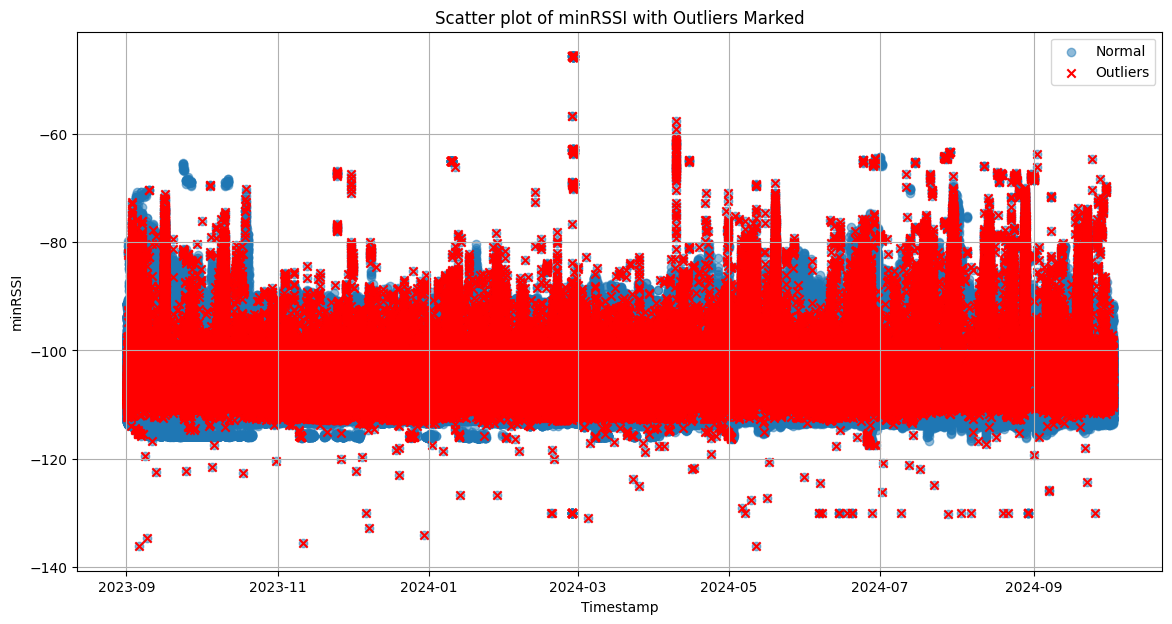

In [8]:
# Scatter plot of df_outlier
plt.figure(figsize=(14, 7))

# Plot non-outliers
plt.scatter(df_outlier.index, df_outlier['minRSSI'], label='Normal', alpha=0.5)

# Plot outliers
outliers = df_outlier[df_outlier['outlier'] == 1]
plt.scatter(outliers.index, outliers['minRSSI'], color='red', label='Outliers', marker='x')

# Formatting the plot
plt.xlabel('Timestamp')
plt.ylabel('minRSSI')
plt.title('Scatter plot of minRSSI with Outliers Marked')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Create 'anomaly' variable
df_outlier['anomaly'] = ((df_outlier['outlier'] == 1) & 
                         (df_outlier['AnomalyDay'] == 1) & 
                         (df_outlier['minRSSI'] > -90)).astype(int)

# Create 'noise' variable
df_outlier['noise'] = ((df_outlier['outlier'] == 1) & 
                       (df_outlier['AnomalyDay'] == 0) & 
                       (~df_outlier['minRSSI'].between(-115, -90))).astype(int)

# Display the head of the updated dataframe
df_outlier.head()

,cell,bts,antenna,carrier,minRSSI,PageSessionTotal,ULvolMByte,AnomalyDay,rolling_mean,rolling_std,outlier,anomaly,noise
timestamp,,,,,,,,,,,,,
2023-09-01 02:30:00+00:00,997_0_0,997,0,0,-109.08,0,0.000000,0,-109.08,NaN,0,0,0
2023-09-01 02:30:00+00:00,580_0_1,580,0,1,-103.58,67,0.150356,0,-103.58,NaN,0,0,0
2023-09-01 02:30:00+00:00,580_1_0,580,1,0,-107.79,0,0.352035,0,-107.79,NaN,0,0,0
2023-09-01 02:30:00+00:00,580_1_1,580,1,1,-107.16,58,0.215608,0,-107.16,NaN,0,0,0
2023-09-01 02:30:00+00:00,580_2_0,580,2,0,-106.63,0,0.184871,0,-106.63,NaN,0,0,0


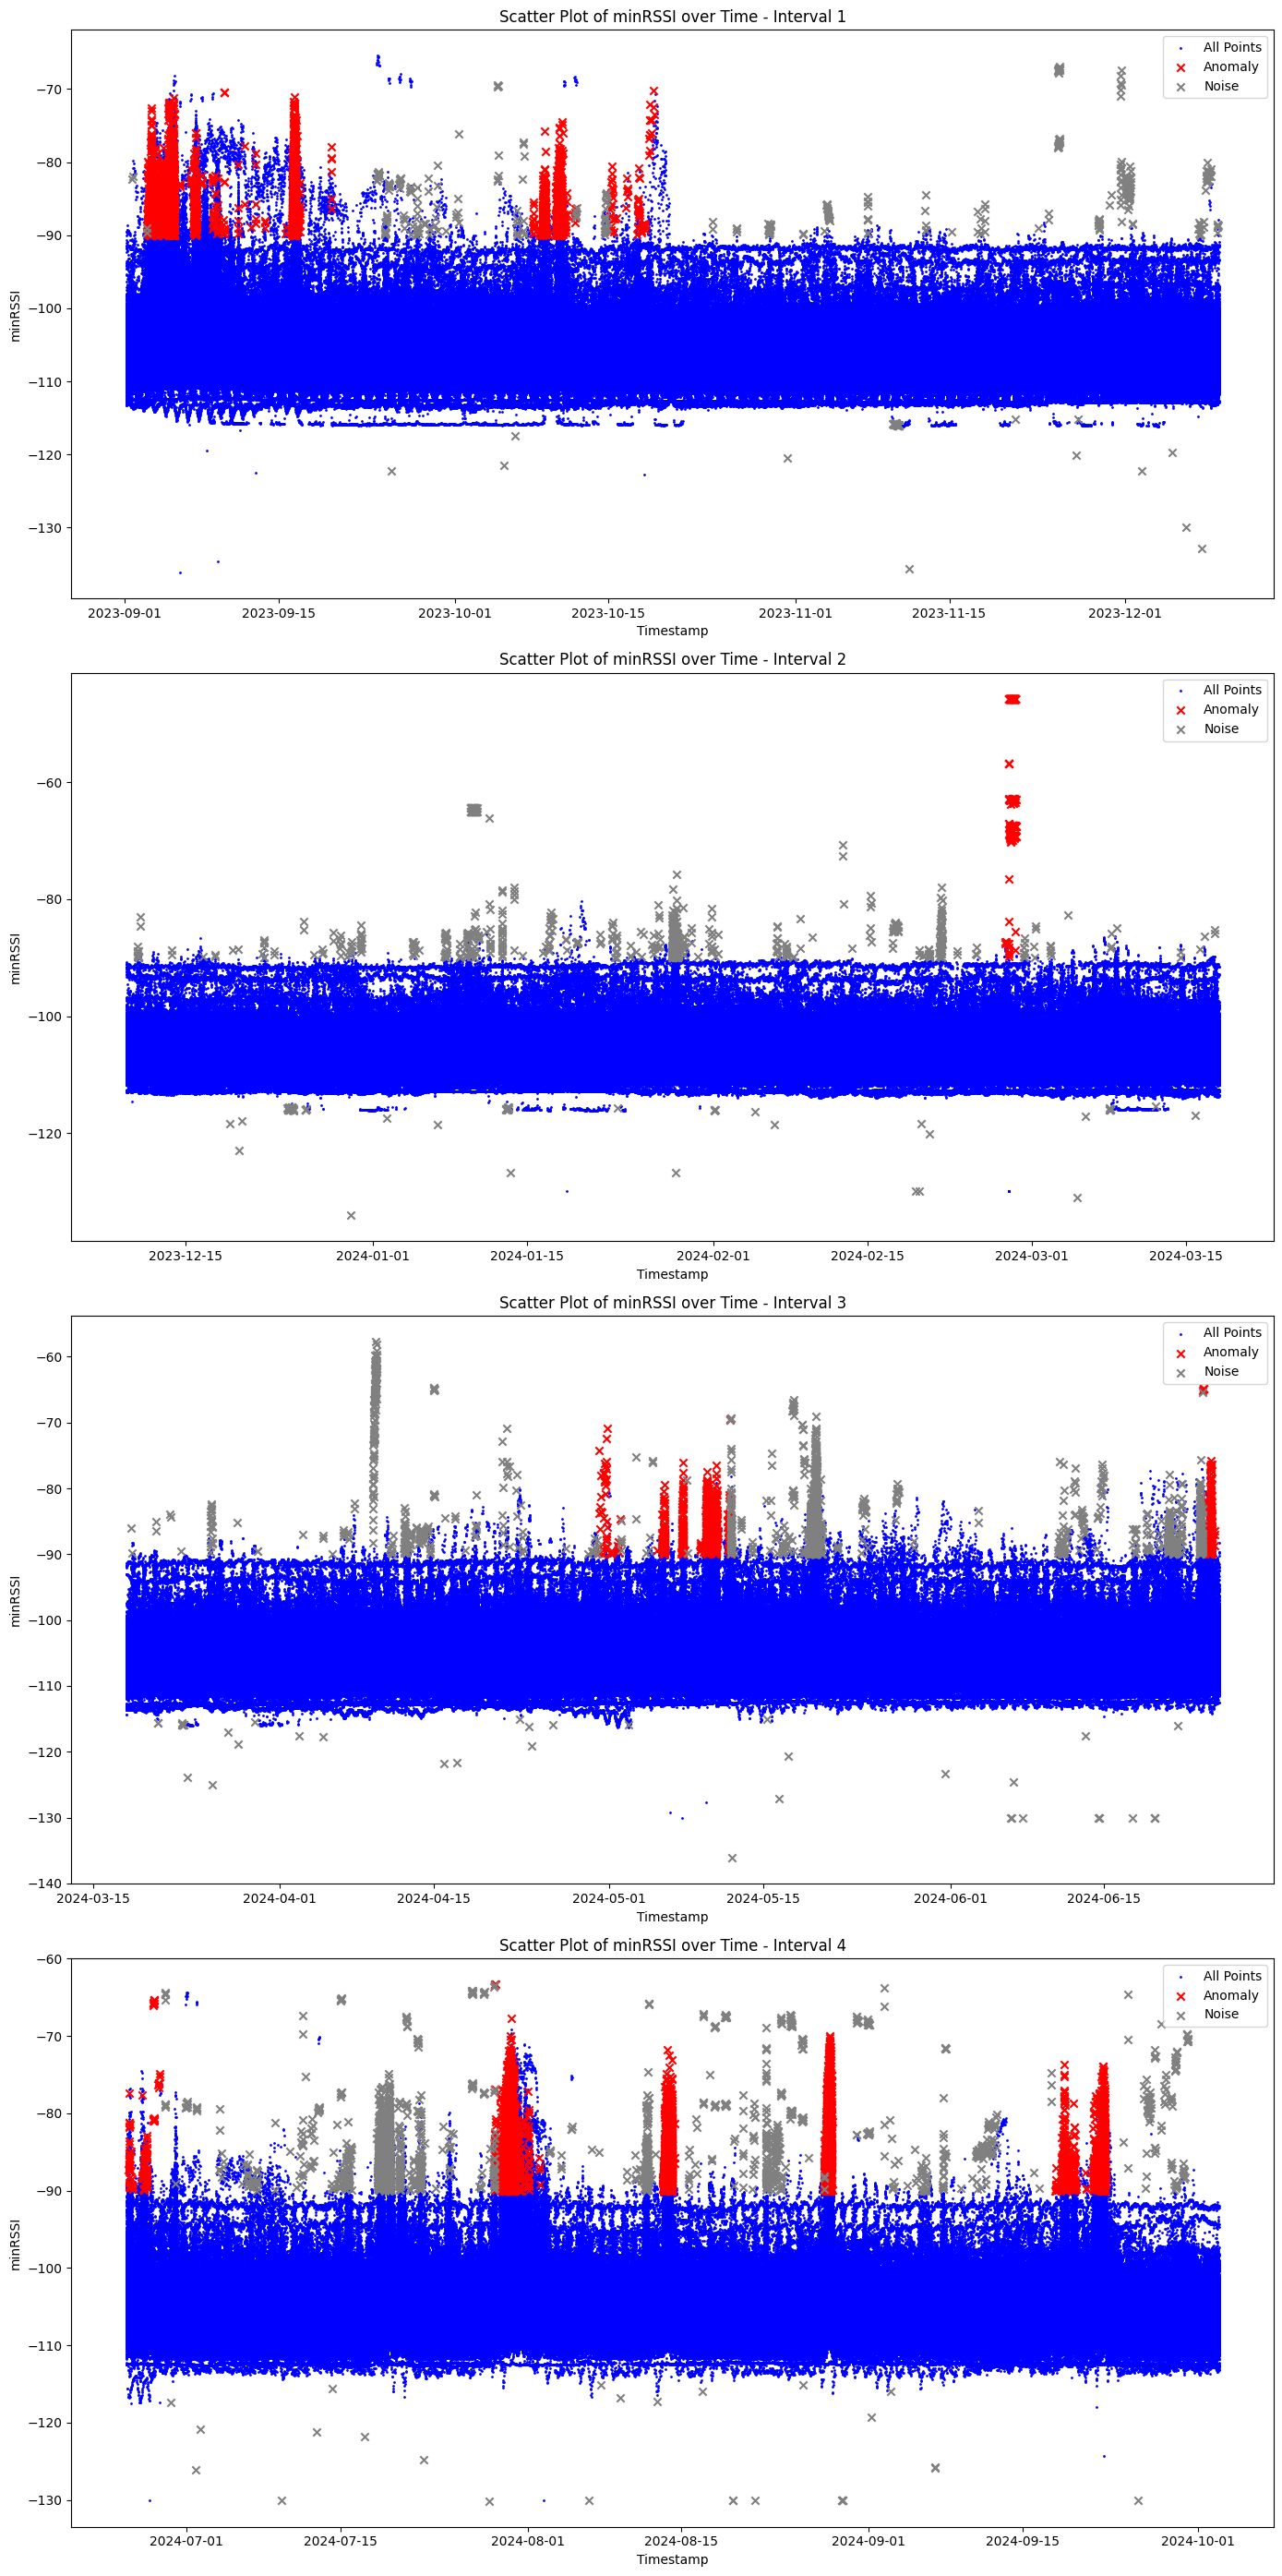

In [15]:
# Define the intervals
interval_start = df_outlier.index.min()
interval_end = df_outlier.index.max()
interval_duration = (interval_end - interval_start) / 4

# Calculate the interval boundaries
intervals = [(interval_start + i * interval_duration, interval_start + (i + 1) * interval_duration) for i in range(4)]

# Ignore warnings
warnings.filterwarnings('ignore')

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 28))

# Plot each interval
for i, (start, end) in enumerate(intervals):
    filtered_df = df_outlier[(df_outlier.index >= start) & (df_outlier.index < end)]
    anomaly_points = filtered_df[filtered_df['anomaly'] == 1]
    noise_points = filtered_df[filtered_df['noise'] == 1]
    
    axs[i].scatter(filtered_df.index, filtered_df['minRSSI'], color='blue', label='All Points', s=1)
    axs[i].scatter(anomaly_points.index, anomaly_points['minRSSI'], color='red', label='Anomaly', marker='x')
    axs[i].scatter(noise_points.index, noise_points['minRSSI'], color='grey', label='Noise', marker='x')
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('minRSSI')
    axs[i].set_title(f'Scatter Plot of minRSSI over Time - Interval {i + 1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [10]:
# Total anomaly instances
total_anomalies = df_outlier['anomaly'].sum()

# Total unique days when anomalies happen
unique_anomaly_days = pd.Series(df_outlier[df_outlier['anomaly'] == 1].index.date).nunique()

# Sum of unique cells where anomalies happen
unique_cells_with_anomalies = df_outlier[df_outlier['anomaly'] == 1]['cell'].nunique()

# Sum of unique cells that are never affected by anomalies
unique_cells_never_affected = df_outlier['cell'].nunique() - unique_cells_with_anomalies

# Sum of bts affected by anomalies
unique_bts_affected = df_outlier[df_outlier['anomaly'] == 1]['bts'].nunique()

# Total noise instances
total_noise_instances = df_outlier['noise'].sum()

print(f'Total anomaly instances: {total_anomalies}')
print(f'Total unique days when anomalies happen: {unique_anomaly_days}')
print(f'Sum of unique cells where anomalies happen: {unique_cells_with_anomalies}')
print(f'Sum of unique cells that are never affected: {unique_cells_never_affected}')
print(f'Sum of bts affected by anomalies: {unique_bts_affected}')
print(f'Total noise instances: {total_noise_instances}')

Total anomaly instances: 11026
Total unique days when anomalies happen: 50
Sum of unique cells where anomalies happen: 281
Sum of unique cells that are never affected: 394
Sum of bts affected by anomalies: 126
Total noise instances: 4231


In [11]:
# Drop rolling mean, rolling std and outlier columns
df_outlier.drop(['rolling_mean', 'rolling_std', 'outlier'], axis=1, inplace=True)

# Save the dataframe to a new CSV file
df_outlier.to_csv('../out/FullData/cell_labeled.csv')